# Tutorial: Removing Cross-Swath Bias in `ssha_karin_2`

---
**Author**: Jinbo Wang   
**Date**: 9/7/2023  
**Revison History**

* 5/29/2024: add direct s3 access and earthaccess

---
⚠️ **Disclaimer: Preliminary** ⚠️

_This project is currently in the process of reprocessing the data. The SWOT data should not be used for scientific analyses. The code provided here is aimed at demonstrating basic techniques for data access, processing, and visualization._

### Prerequisites
Before proceeding with this tutorial, you'll need to download the SWOT KaRIn Expert product. This code is explicit on visualization. Major analysis is done by the routine `swot_ssh_utils.fit_bias`. 

In [1]:
import pylab as plt
import numpy as np
import sys
sys.path.append('../src/')
import swot_ssh_utils as swot
from cartopy import crs as ccrs
from glob import glob
import earthaccess 
import xarray as xr
#uncomment the following line to install earthaccess if it is not yet installed
# !pip install earthaccess

def load_and_plot_ssha_data(data):
    """
    data is a swot.SSH_L2 instance with Expert input
    
    Returns:
    None
    """

    # Preprocess data
    ssha = data.Expert.ssha_karin_2
    flag = data.Expert.ancillary_surface_classification_flag
    ssha = np.where(flag == 0, ssha, np.nan)
    lon = data.Expert.longitude.values
    lat = data.Expert.latitude.values
    distance = data.Expert.cross_track_distance.values
    
    # Create plots
    fig, ax = plt.subplots(
        figsize=(5, 4),
        ncols=2,
        nrows=1,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    
    # Plot original data
    swot.plot_a_segment(ax[0], lon, lat, ssha, title='SSHA_KaRIn_2 original', vmin=-5, vmax=5)
    
    # Bias correction (optional)
    ssha_1 = swot.fit_bias(
        ssha, distance,
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )
    
    # mask out data in nadir and outside of 60km swath width
    distance = np.nanmean(distance, axis=0 )
    msk = (np.abs(distance) < 60e3) & (np.abs(distance) > 10e3)
    lon[:, ~msk] = np.nan
    lat[:, ~msk] = np.nan
    ssha_1[:, ~msk] = np.nan

    # Plot bias corrected data
    swot.plot_a_segment(ax[1], lon, lat, ssha_1, title='SSHA_KaRIn_2 bias corrected', vmin=-0.2, vmax=0.2)
    
    # Save and display plot
    plt.tight_layout()
    #plt.savefig('../media/figures/ssha_karin_2_california.png', dpi=100)

## Use earthaccess to find data

In [2]:
auth = earthaccess.login()
ssh_results = earthaccess.search_data(short_name = 'SWOT_L2_LR_SSH_Expert_2.0', 
                                      #temporal = ("2023-04-23 00:00:00", "2023-04-24 23:59:59"),
                                      granule_name = '*_Expert_???_013_*') #use pass number to narrow down the search


Granules found: 9


## Download and analyze

In [3]:
# Make a folder name data_downloads
earthaccess.download(ssh_results[0], "./data_downloads/")

 Getting 1 granules, approx download size: 0.03 GB
Accessing cloud dataset using dataset endpoint credentials: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials
Downloaded: data_downloads/SWOT_L2_LR_SSH_Expert_007_013_20231123T202137_20231123T211305_PIC0_01.nc


[PosixPath('data_downloads/SWOT_L2_LR_SSH_Expert_007_013_20231123T202137_20231123T211305_PIC0_01.nc')]

In [4]:
ds = xr.open_mfdataset("./data_downloads/SWOT_L2_LR_SSH_Expert*.nc")
display(ds)

<xarray.Dataset> Size: 400MB
Dimensions:                                (num_lines: 9866, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) datetime64[ns] 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) datetime64[ns] 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_qual                         (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation                 (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2023-11-25T21:23:38Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       65.76645448005515
    ssha_variance:                                 0.11614050683132866
    references:                                    V1.2.1
    equator_longitude:                             -155.17

In [5]:
lat_bounds = [33, 44]

data=swot.SSH_L2()
data.load_data('data_downloads/SWOT_L2_LR_SSH_Expert_007_013_20231123T202137_20231123T211305_PIC0_01.nc',
              lat_bounds=lat_bounds)
display(data.Expert)

<xarray.Dataset> Size: 25MB
Dimensions:                                (num_lines: 626, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude_nadir                         (num_lines) float64 5kB 33.01 ... ...
    longitude_nadir                        (num_lines) float64 5kB 210.6 ... ...
    latitude                               (num_lines, num_pixels) float64 346kB ...
    longitude                              (num_lines, num_pixels) float64 346kB ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) datetime64[ns] 5kB ...
    time_tai                               (num_lines) datetime64[ns] 5kB ...
    ssh_karin                              (num_lines, num_pixels) float64 346kB ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 346kB ...
    ssh_karin_uncert                       (num_lines, num_pixels) float64 346kB ...
    ssha_karin                             (num_lines, num_pixels) float64 346kB ...
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 173kB ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 173kB ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 173kB ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 173kB ...
    volumetric_correlation                 (num_lines, num_pixels) float64 346kB ...
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 346kB ...
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2023-11-25T21:23:38Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       65.76645448005515
    ssha_variance:                                 0.11614050683132866
    references:                                    V1.2.1
    equator_longitude:                             -155.17

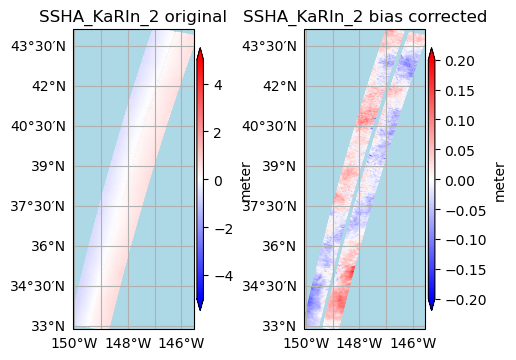

In [6]:
load_and_plot_ssha_data(data)

## Direct S3 access in the AWS cloud

In [7]:
auth = earthaccess.login()
ssh_results = earthaccess.search_data(short_name = 'SWOT_L2_LR_SSH_Expert_2.0', 
                                      #temporal = ("2023-08-10 00:00:00", "2023-08-24 23:59:59"))
                                      granule_name = '*_Expert_???_013_*') 
ds = xr.open_mfdataset(earthaccess.open([ssh_results[0]]))#, mask_and_scale=False)
ds

Granules found: 9
Opening 1 granules, approx size: 0.03 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 400MB
Dimensions:                                (num_lines: 9866, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) datetime64[ns] 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) datetime64[ns] 79kB dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_qual                         (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 3MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation                 (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 5MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2023-11-25T21:23:38Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       65.76645448005515
    ssha_variance:                                 0.11614050683132866
    references:                                    V1.2.1
    equator_longitude:                             -155.17

In [8]:
data_links = [granule.data_links(access="direct") for granule in ssh_results]
display(data_links)

[['s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_007_013_20231123T202137_20231123T211305_PIC0_01.nc'],
 ['s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_008_013_20231214T170641_20231214T175809_PIC0_01.nc'],
 ['s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_009_013_20240104T135148_20240104T144316_PIC0_01.nc'],
 ['s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_010_013_20240125T103653_20240125T112821_PIC0_01.nc'],
 ['s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_011_013_20240215T072158_20240215T081326_PIC0_01.nc'],
 ['s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_012_013_20240307T040702_20240307T045830_PIC0_01.nc'],
 ['s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_013_013_20240328T005206_20240328T014334_PIC0_01.nc'],
 ['s3://podaac-swot-ops-cumulus-protected

In [37]:
data=swot.SSH_L2()
s3sys=swot.init_S3FileSystem()

data.load_data(data_links[0][0],s3sys,lat_bounds)
display(data.Expert)


<xarray.Dataset> Size: 25MB
Dimensions:                                (num_lines: 626, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude_nadir                         (num_lines) float64 5kB 33.01 ... ...
    longitude_nadir                        (num_lines) float64 5kB 210.6 ... ...
    latitude                               (num_lines, num_pixels) float64 346kB ...
    longitude                              (num_lines, num_pixels) float64 346kB ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) datetime64[ns] 5kB ...
    time_tai                               (num_lines) datetime64[ns] 5kB ...
    ssh_karin                              (num_lines, num_pixels) float64 346kB ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 346kB ...
    ssh_karin_uncert                       (num_lines, num_pixels) float64 346kB ...
    ssha_karin                             (num_lines, num_pixels) float64 346kB ...
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 173kB ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 173kB ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 173kB ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 173kB ...
    volumetric_correlation                 (num_lines, num_pixels) float64 346kB ...
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 346kB ...
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2023-11-25T21:23:38Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       65.76645448005515
    ssha_variance:                                 0.11614050683132866
    references:                                    V1.2.1
    equator_longitude:                             -155.17

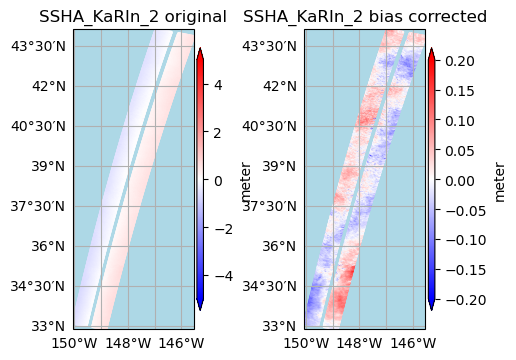

In [9]:
load_and_plot_ssha_data(data)